In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


In [2]:
def single_run(d_easy, d_hard, theta, var, ns, verbose=False):
    test_on_all = True

    # data distribution
    cov_all, cov_easy_no, cov_hard_no = var*np.eye(d_easy + d_hard), var*np.eye(d_easy + d_hard), var*np.eye(d_easy + d_hard)
    covs = [cov_easy_no, cov_hard_no, cov_all] # all the same for now

    n_tot_train  = np.sum(ns)
    n_tot_pseudo = np.sum(ns) # pseudolabel set
    n_tot_test   = np.sum(ns) # test set for final eval
    X_train   = np.zeros([n_tot_train, d_easy + d_hard]) # data matrix
    X_pseudo  = np.zeros([n_tot_pseudo, d_easy + d_hard]) # data matrix
    X_test    = np.zeros([n_tot_test, d_easy + d_hard]) # data matrix

    y_train, y_pseudo, y_test = np.zeros(n_tot_train), np.zeros(n_tot_pseudo), np.zeros(n_tot_test)
    idx, j = 0, 0

    for n in ns:
        # gaussian samples
        pts_train = np.random.multivariate_normal(np.zeros(d_easy+d_hard), covs[j], size=n)
        pts_pseudo = np.random.multivariate_normal(np.zeros(d_easy+d_hard), covs[j], size=n)
        pts_test = np.random.multivariate_normal(np.zeros(d_easy+d_hard), covs[j], size=n)
        for i in range(n):
            # generate the labels for all the sets. binary labels uniform prior
            y_train[idx+i] = np.random.randint(2)
            y_pseudo[idx+i] = np.random.randint(2)
            y_test[idx+i] = np.random.randint(2)

            if y_train[idx+i]:
                pts_train[i] += theta #np.ones(d_easy + d_hard) 
            else:
                pts_train[i] -= theta #np.ones(d_easy + d_hard) 
            if y_pseudo[idx+i]:
                pts_pseudo[i] += theta #np.ones(d_easy + d_hard) 
            else:
                pts_pseudo[i] -= theta #np.ones(d_easy + d_hard) 
            if y_test[idx+i]:
                pts_test[i] += theta #np.ones(d_easy + d_hard) 
            else:
                pts_test[i] -= theta #np.ones(d_easy + d_hard) 

        X_train[idx:idx+n], X_pseudo[idx:idx+n], X_test[idx:idx+n] = pts_train, pts_pseudo, pts_test
        if j == 0: # easy only
            X_train[idx:idx+n,d_easy:] = np.zeros([n, d_hard])
            X_pseudo[idx:idx+n,d_easy:] = np.zeros([n, d_hard])
            X_test[idx:idx+n,d_easy:] = np.zeros([n, d_hard])
        elif j == 1: # hard only
            X_train[idx:idx+n,:d_easy] = np.zeros([n, d_easy])
            X_pseudo[idx:idx+n,:d_easy] = np.zeros([n, d_easy])
            X_test[idx:idx+n,:d_easy] = np.zeros([n, d_easy])

        idx += n
        j += 1
    
    # simulate a weak model that cannot take advantage of hard features by zeroing features
    X_weak_train = np.copy(X_train)
    X_weak_train[:, d_easy:] = np.zeros([ns[0]+ns[1]+ns[2], d_hard])  # all points get hard features zero'd out

    X_weak_pseudo = np.copy(X_pseudo)
    X_weak_pseudo[:, d_easy:] = np.zeros([ns[0]+ns[1]+ns[2], d_hard])  # all points get hard features zero'd out

    X_weak_test = np.copy(X_test)
    X_weak_test[:, d_easy:] = np.zeros([ns[0]+ns[1]+ns[2], d_hard])  # all points get hard features zero'd out

    # train classifiers
    weak_model = LogisticRegression(random_state=0, fit_intercept=False).fit(X_weak_train, y_train)
    weak_train_acc_overall = weak_model.score(X_weak_train, y_train)

    if test_on_all:
        weak_test_acc_overall  = weak_model.score(X_weak_test, y_test)
    else:
        # test on hard for debugging 
        weak_test_acc_overall  = weak_model.score(X_weak_test[ns[0]:ns[0]+ns[1]], y_test[ns[0]:ns[0]+ns[1]])


    # how good was the accuracy on just easy points?
    weak_train_acc_easy = weak_model.score(X_weak_train[:ns[0]], y_train[:ns[0]])
    if verbose:
        print(f"weak model train acc on easy alone = {weak_train_acc_easy}")

    # how good was the accuracy on just overlaps?
    weak_train_acc_overlaps = weak_model.score(X_weak_train[ns[0]+ns[1]:], y_train[ns[0]+ns[1]:])
    if verbose:
        print(f"weak model train acc on overlaps = {weak_train_acc_overlaps}") 

    # oracle
    strong_model_oracle = LogisticRegression(random_state=0, fit_intercept=False).fit(X_train, y_train)
    if test_on_all:
        strong_test_acc_oracle = strong_model_oracle.score(X_test, y_test)
    else:
        strong_test_acc_oracle = strong_model_oracle.score(X_test[ns[0]:ns[0]+ns[1]], y_test[ns[0]:ns[0]+ns[1]])

    # pseudolabels generated...
    y_pseudolabels = weak_model.predict(X_weak_pseudo)
    correct_easy = np.sum(y_pseudo[:ns[0]] == y_pseudolabels[:ns[0]])
    correct_overlaps = np.sum(y_pseudo[ns[0]+ns[1]:] == y_pseudolabels[ns[0]+ns[1]:])
    if verbose:
        print(f"correct easy was {correct_easy} at this level acc = {correct_easy/ns[0]}")
        print(f"correct overlaps was {correct_overlaps} at this level acc = {correct_overlaps/ns[2]}")

    # hard only
    # strong_model = LogisticRegression(random_state=0).fit(X_pseudo, y_pseudolabels)
    # num_others = 50
    # X_w2s_train = np.concatenate([X_pseudo[:num_others], X_pseudo[ns[0]:ns[0]+num_others], X_pseudo[ns[0]+ns[1]:]])
    # y_w2s_train = np.concatenate([y_pseudolabels[:num_others], y_pseudolabels[ns[0]:ns[0]+num_others], y_pseudolabels[ns[0]+ns[1]:]])
    # strong_model_train_overlaps = LogisticRegression(random_state=0, C=0.01, fit_intercept=False).fit(X_w2s_train, y_w2s_train)
    strong_model_train_overlaps = LogisticRegression(random_state=0, C=0.01).fit(X_pseudo[ns[0]+ns[1]:], y_pseudolabels[ns[0]+ns[1]:])
    # strong_model_train_overlaps = LogisticRegression(random_state=0, C=0.01).fit(X_pseudo[ns[1]+ns[2]:], y_pseudolabels[ns[1]+ns[2]:])
    
    # all for debugging. first one means no label noise!
    #strong_model_train_overlaps = LogisticRegression(random_state=0).fit(X_pseudo[ns[1]+ns[2]:], y_pseudo[ns[1]+ns[2]:])
    #weights = strong_model_train_overlaps.coef_
    #print(f"true weights = \n{theta[:d_easy]}\n{theta[d_easy:2*d_easy]}")
    #print(f"lrnd weights = \n{weights[0][:d_easy]}\n{weights[0][d_easy:2*d_easy]}")
    #print(f"learned weights ={weights}")

    # strong_pseudo_acc_overlaps = strong_model_train_overlaps.score(X_pseudo[ns[1]+ns[2]:], y_pseudolabels[ns[1]+ns[2]:])
    strong_pseudo_acc_overlaps = strong_model_train_overlaps.score(X_pseudo[ns[0]:ns[0]+ns[1]], y_pseudolabels[ns[0]:ns[0]+ns[1]])
    if verbose:
        print(f"strong model trained on overlaps, fitting on pseudo overlaps = {strong_pseudo_acc_overlaps}") 

    #strong_model_full = LogisticRegression(random_state=0).fit(X_pseudo, y_pseudolabels)
    #strong_pseudo_acc = strong_model_full.score(X_pseudo, y_pseudo)
    #print(f"strong model trained on all pseudolabels, fitting on all pseudo= {strong_pseudo_acc}") 

    strong_pseudo_acc_pseudo_easy = strong_model_train_overlaps.score(X_pseudo[:ns[0]], y_pseudolabels[:ns[0]])
    strong_pseudo_acc_easy = strong_model_train_overlaps.score(X_pseudo[:ns[0]], y_pseudo[:ns[0]])
    strong_pseudo_acc_hard = strong_model_train_overlaps.score(X_pseudo[ns[1]:ns[1]+ns[2]], y_pseudo[ns[1]:ns[1]+ns[2]])
    if verbose:
        print(f"strong model train overlaps test on pseudo easy = {strong_pseudo_acc_pseudo_easy}") 
        print(f"strong model train overlaps test on true easy = {strong_pseudo_acc_easy}") 
        print(f"strong model train overlaps test on true hard = {strong_pseudo_acc_hard}") 

    if test_on_all:
        strong_model_test_acc = strong_model_train_overlaps.score(X_test, y_test)
    else:
        strong_model_test_acc = strong_model_train_overlaps.score(X_test[ns[0]:ns[0]+ns[1]], y_test[ns[0]:ns[0]+ns[1]])
    if verbose:
        print(f"All points strong model acc = {strong_model_test_acc}")
        print()

    X_test_easy, y_test_easy = X_test[:ns[0]], y_test[:ns[0]]
    X_test_hard, y_test_hard = X_test[ns[0]:ns[0]+ns[1]], y_test[ns[0]:ns[0]+ns[1]]
    X_test_overlap, y_test_overlap = X_test[ns[0]+ns[1]:], y_test[ns[0]+ns[1]:]
    
    weak_easy_acc = weak_model.score(X_test_easy, y_test_easy)
    weak_hard_acc = weak_model.score(X_test_hard, y_test_hard)
    weak_overlap_acc = weak_model.score(X_test_overlap, y_test_overlap)

    strong_easy_acc = strong_model_oracle.score(X_test_easy, y_test_easy)
    strong_hard_acc = strong_model_oracle.score(X_test_hard, y_test_hard)
    strong_overlap_acc = strong_model_oracle.score(X_test_overlap, y_test_overlap)

    w2s_easy_acc = strong_model_train_overlaps.score(X_test_easy, y_test_easy)
    w2s_hard_acc = strong_model_train_overlaps.score(X_test_hard, y_test_hard)
    w2s_overlap_acc = strong_model_train_overlaps.score(X_test_overlap, y_test_overlap)

    result = {
        'weak_acc': weak_test_acc_overall,
        'strong_acc': strong_test_acc_oracle,
        'w2s_acc': strong_model_test_acc,
        'weak_easy_acc': weak_easy_acc,
        'weak_hard_acc': weak_hard_acc,
        'weak_overlap_acc': weak_overlap_acc,
        'strong_easy_acc': strong_easy_acc,
        'strong_hard_acc': strong_hard_acc,
        'strong_overlap_acc': strong_overlap_acc,
        'w2s_easy_acc': w2s_easy_acc,
        'w2s_hard_acc': w2s_hard_acc,
        'w2s_overlap_acc': w2s_overlap_acc
    }

    return result



In [3]:
#np.random.seed(0x1234)
# tot_runs = 500
tot_runs = 50

ratio = 1
d_easy = 20
d_hard = d_easy * ratio
total_overlap_choices = 20

var = 5.0
accs = np.zeros([total_overlap_choices-1, 3])
df = []
for j in range(tot_runs):
    theta = np.random.rand(d_easy + d_hard) # single parameter vector

    for overlap in range(0,total_overlap_choices):
        try:
            ns = [100, overlap*5, 10] # easy non-overlap, hard non-overlap, overlaps. total points is always 400
            #ns = [1000, 1000, 300+overlap*100] # easy non-overlap, hard non-overlap, overlaps. total points is always 400
            result = single_run(d_easy, d_hard, theta, var, ns, verbose=False) 
            result['it'] = j
            result['n_easy'] = ns[0]
            result['n_hard'] = ns[1]
            result['n_overlap'] = ns[2]
            df.append(result)
        except Exception as e:
            continue

    if j%10 == 0:
        print(f"finished run {j}")

df = pd.DataFrame(df)
df.to_csv('synthetic_accuracy_decomposition.csv', index=False)

finished run 0
finished run 10
finished run 20
finished run 30
finished run 40
finished run 50
finished run 60
finished run 70
finished run 80
finished run 90
finished run 100
finished run 110
finished run 120
finished run 130
finished run 140
finished run 150
finished run 160
finished run 170
finished run 180
finished run 190
finished run 200
finished run 210
finished run 220
finished run 230
finished run 240
finished run 250
finished run 260
finished run 270
finished run 280
finished run 290
finished run 300
finished run 310
finished run 320
finished run 330
finished run 340
finished run 350
finished run 360
finished run 370
finished run 380
finished run 390
finished run 400
finished run 410
finished run 420
finished run 430
finished run 440
finished run 450
finished run 460
finished run 470
finished run 480
finished run 490


In [4]:
df = pd.DataFrame(df)

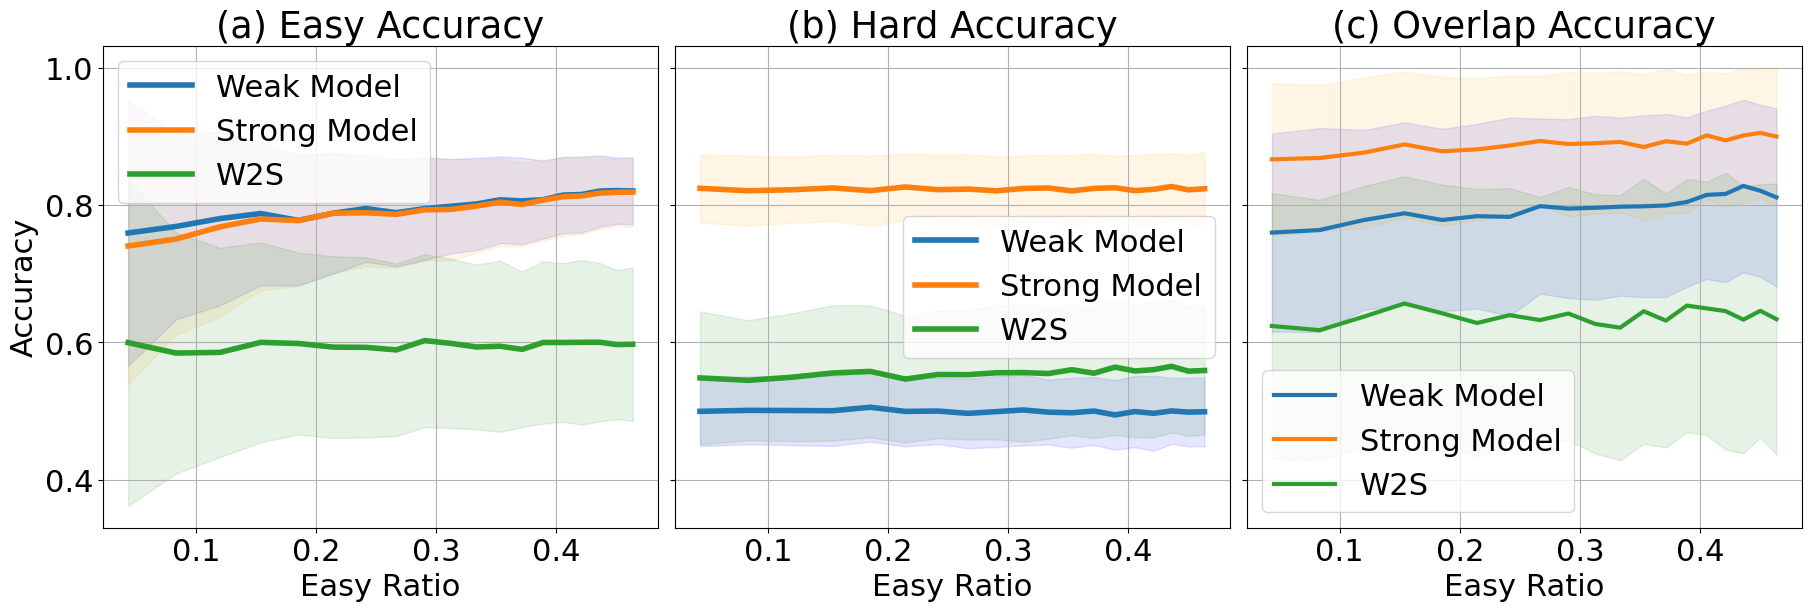

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

df['overlap_ratio'] = df['n_hard'] / (df['n_easy'] + df['n_hard'] + df['n_overlap'])
df_mean = df.groupby(['n_easy', 'n_hard', 'n_overlap']).mean().reset_index()
df_std = df.groupby(['n_easy', 'n_hard', 'n_overlap']).std().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey=True, layout='constrained')
line_width = 4

# Easy
axes[0].plot(df_mean['overlap_ratio'], df_mean['weak_easy_acc'], linewidth=line_width, label='Weak Model')
axes[0].plot(df_mean['overlap_ratio'], df_mean['strong_easy_acc'], linewidth=line_width, label='Strong Model')
axes[0].plot(df_mean['overlap_ratio'], df_mean['w2s_easy_acc'], linewidth=line_width, label='W2S')

axes[0].fill_between(df_mean['overlap_ratio'], df_mean['weak_easy_acc']-df_std['weak_easy_acc'],
                     df_mean['weak_easy_acc']+df_std['weak_easy_acc'], color='blue', alpha=0.1)
axes[0].fill_between(df_mean['overlap_ratio'], df_mean['strong_easy_acc']-df_std['strong_easy_acc'],
                     df_mean['strong_easy_acc']+df_std['strong_easy_acc'], color='orange', alpha=0.1)
axes[0].fill_between(df_mean['overlap_ratio'], df_mean['w2s_easy_acc']-df_std['w2s_easy_acc'],
                     df_mean['w2s_easy_acc']+df_std['w2s_easy_acc'], color='green', alpha=0.1)
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel('Hard Ratio')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('(a) Easy Accuracy')


# Hard
axes[1].plot(df_mean['overlap_ratio'], df_mean['weak_hard_acc'], linewidth=line_width, label='Weak Model')
axes[1].plot(df_mean['overlap_ratio'], df_mean['strong_hard_acc'], linewidth=line_width, label='Strong Model')
axes[1].plot(df_mean['overlap_ratio'], df_mean['w2s_hard_acc'], linewidth=line_width, label='W2S')

axes[1].fill_between(df_mean['overlap_ratio'], df_mean['weak_hard_acc']-df_std['weak_hard_acc'],
                     df_mean['weak_hard_acc']+df_std['weak_hard_acc'], color='blue', alpha=0.1)
axes[1].fill_between(df_mean['overlap_ratio'], df_mean['strong_hard_acc']-df_std['strong_hard_acc'],
                     df_mean['strong_hard_acc']+df_std['strong_hard_acc'], color='orange', alpha=0.1)
axes[1].fill_between(df_mean['overlap_ratio'], df_mean['w2s_hard_acc']-df_std['w2s_hard_acc'],
                    df_mean['w2s_hard_acc']+df_std['w2s_hard_acc'], color='green', alpha=0.1)
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel('Hard Ratio')
axes[1].set_title('(b) Hard Accuracy')

# Overlap
axes[2].plot(df_mean['overlap_ratio'], df_mean['weak_overlap_acc'], linewidth=3, label='Weak Model')
axes[2].plot(df_mean['overlap_ratio'], df_mean['strong_overlap_acc'], linewidth=3, label='Strong Model')
axes[2].plot(df_mean['overlap_ratio'], df_mean['w2s_overlap_acc'], linewidth=3, label='W2S')

axes[2].fill_between(df_mean['overlap_ratio'], df_mean['weak_overlap_acc']-df_std['weak_overlap_acc'],
                     df_mean['weak_overlap_acc']+df_std['weak_overlap_acc'], color='blue', alpha=0.1)
axes[2].fill_between(df_mean['overlap_ratio'], df_mean['strong_overlap_acc']-df_std['strong_overlap_acc'],
                     df_mean['strong_overlap_acc']+df_std['strong_overlap_acc'], color='orange', alpha=0.1)
axes[2].fill_between(df_mean['overlap_ratio'], df_mean['w2s_overlap_acc']-df_std['w2s_overlap_acc'],
                     df_mean['w2s_overlap_acc']+df_std['w2s_overlap_acc'], color='green', alpha=0.1)
axes[2].grid()
axes[2].legend()
axes[2].set_xlabel('Hard Ratio')
axes[2].set_title('(c) Overlap Accuracy')

fig.savefig('synthetic_exp_hard_ratio_analysis.pdf', dpi=300)

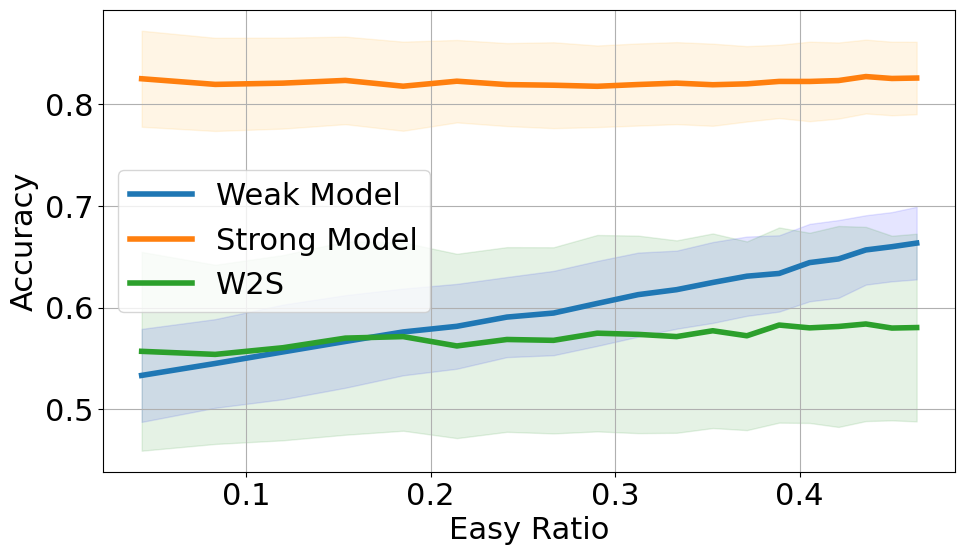

In [6]:
# Overall Accuracy
plt.figure(figsize=(11, 6))
plt.plot(df_mean['overlap_ratio'], df_mean['weak_acc'], linewidth=line_width, label='Weak Model')
plt.plot(df_mean['overlap_ratio'], df_mean['strong_acc'], linewidth=line_width, label='Strong Model')
plt.plot(df_mean['overlap_ratio'], df_mean['w2s_acc'], linewidth=line_width, label='W2S')

plt.fill_between(df_mean['overlap_ratio'], df_mean['weak_acc']-df_std['weak_acc'],
                     df_mean['weak_acc']+df_std['weak_acc'], color='blue', alpha=0.1)
plt.fill_between(df_mean['overlap_ratio'], df_mean['strong_acc']-df_std['strong_acc'],
                     df_mean['strong_acc']+df_std['strong_acc'], color='orange', alpha=0.1)
plt.fill_between(df_mean['overlap_ratio'], df_mean['w2s_acc']-df_std['w2s_acc'],
                     df_mean['w2s_acc']+df_std['w2s_acc'], color='green', alpha=0.1)
plt.grid()
plt.legend()
plt.xlabel('Easy Ratio')
plt.ylabel('Accuracy')
# plt.title('Overall Accuracy')
plt.savefig('synthetic_exp_hard_ratio_analysis_overall_acc.pdf', dpi=300, bbox_inches='tight')